# Basic Imports and Data + Model Loading

In [1]:
# Data loading
from glob import glob
from pathlib import Path
import joblib
from dataclasses import dataclass

# Key imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from scipy.stats import uniform, randint

# Preprocessing
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, VarianceThreshold
from sklearn.model_selection import StratifiedKFold 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from sklearn.base import clone
from sklearn.utils import resample
from scipy.stats import norm

# ML implementation
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.dummy import DummyClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from lifelines import KaplanMeierFitter,CoxPHFitter

# Hyperparameter tuning
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, HalvingGridSearchCV, HalvingRandomSearchCV
from skopt import BayesSearchCV

# Model evaluation
import sklearn.metrics as skmetrics
import imblearn.metrics as imbmetrics

In [2]:
import warnings
import os
import sys
from sklearn.exceptions import ConvergenceWarning
from IPython.core.interactiveshell import InteractiveShell

# Suppress Python warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [3]:
# Set configuration
config = "config1"

# Set project root (where PreppedData and TunedModels live)
project_root = Path.cwd()
print(f"Project root directory: {project_root}")

# Define data and model directories
prepped_data_dir = project_root / f"PreppedData_{config}"
model_dir = project_root / f"TunedModels_{config}"
bootstrap_results_dir = project_root/f"BootstrapResults_{config}"

# Validate directories exist
if not prepped_data_dir.exists():
    raise FileNotFoundError(f"Prepped data directory not found at: {prepped_data_dir}")
if not model_dir.exists():
    raise FileNotFoundError(f"Model directory not found at: {model_dir}")

# Load data
data_file = prepped_data_dir / f'combined_log_transformed_{config}.npz'
data = np.load(data_file)
print(f"Loaded data from {data_file}")

# Display relevant summary stats
n_split = 5
shuffle = True
random_state = 42

X = data['X']
y = data['y']

print('X:')
display(X)
print('\nClass counts:', Counter(y))
print('\nX shape:', X.shape, 'y shape:', y.shape)
print('\nUnique class labels:', np.unique(y))

Project root directory: /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SampleSizePowerCalc
Loaded data from /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SampleSizePowerCalc/PreppedData_config1/combined_log_transformed_config1.npz
X:


array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        7.47222030e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        8.29809237e-05, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])


Class counts: Counter({np.int64(0): 1734, np.int64(1): 1331})

X shape: (3065, 2947) y shape: (3065,)

Unique class labels: [0 1]


# Generating learning curves

In [4]:
import numpy as np
from scipy.stats import norm
from sklearn.utils import resample
from sklearn.metrics import (
    accuracy_score, recall_score, precision_score,
    f1_score, roc_auc_score, average_precision_score
)
from imblearn.metrics import geometric_mean_score
import os
import joblib
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from joblib import Parallel, delayed
from typing import Callable, Sequence, Literal, Optional, Dict, Union
from sklearn.base import ClassifierMixin
from numpy.typing import ArrayLike

def evaluate_metric(y_true: ArrayLike, y_pred: ArrayLike, y_prob: ArrayLike,
                    metric: str = 'accuracy', pos_label: int = 1) -> float:
    """
    Compute a performance metric based on predictions and class probabilities.

    Parameters:
    - y_true: array-like of true class labels
    - y_pred: array-like of predicted class labels
    - y_prob: array-like of predicted positive class probabilities
    - metric: performance metric name
    - pos_label: label of the positive class (default=1)

    Returns:
    - metric_value: float
    """
    pred_metrics = ['accuracy', 'sensitivity', 'recall', 'precision', 'specificity', 'f1_score', 'gmean']
    predprob_metrics = ['roc_auc', 'average_precision']
    accepted_metrics = pred_metrics + predprob_metrics

    if metric not in accepted_metrics:
        raise ValueError(f"Metric '{metric}' not supported. Choose from {accepted_metrics}")

    if y_true is None or len(y_true) == 0:
        raise ValueError("y_true must be a non-empty array")

    if metric in pred_metrics:
        if y_pred is None or len(y_pred) == 0:
            raise ValueError(f"y_pred must be provided for metric '{metric}'")

    if metric in predprob_metrics:
        if y_prob is None or len(y_prob) == 0:
            raise ValueError(f"y_prob must be provided for metric '{metric}'")

    if metric == 'accuracy':
        return accuracy_score(y_true, y_pred)

    elif metric in ['sensitivity', 'recall']:
        return recall_score(y_true, y_pred, pos_label=pos_label)

    elif metric == 'precision':
        return precision_score(y_true, y_pred, pos_label=pos_label)

    elif metric == 'specificity':
        # True Negative Rate: TN / (TN + FP)
        tn = np.sum((y_true != pos_label) & (y_pred != pos_label))
        fp = np.sum((y_true != pos_label) & (y_pred == pos_label))
        return tn / (tn + fp) if (tn + fp) > 0 else 0.0

    elif metric == 'f1_score':
        return f1_score(y_true, y_pred, pos_label=pos_label)

    elif metric == 'roc_auc':
        return roc_auc_score(y_true, y_prob)

    elif metric == 'average_precision':
        return average_precision_score(y_true, y_prob)

    elif metric == 'gmean':
        return geometric_mean_score(y_true, y_pred, pos_label=pos_label)

    # fallback (should never hit)
    raise ValueError(f"Unhandled metric: {metric}")

In [5]:
MetricName = Literal[
    'accuracy', 'sensitivity', 'recall', 'precision',
    'specificity', 'f1_score', 'roc_auc',
    'average_precision', 'gmean'
]

def subsample_skcv(X: ArrayLike,
                 y: ArrayLike,
                 model: ClassifierMixin,
                 seed: int,
                 metrics: Sequence[MetricName],
                 n_samples_inner: int, 
                 n_splits: int = 5,
                 train_track: bool = False) -> tuple[Optional[dict[str, float]], dict[str, float]]:
    """
    Runs one stratified k-fold cross validation iteration
    at a specified number of subsampled training samples..
    Clones of the model are fitted to each cv split to avoid data leakage.
    Utilised for parallelised execution for all subsamples.

    Parameters:
    - X: Feature matrix (array-like)
    - y: Target array (array-like)
    - model: sklearn model (in a pipeline) used to perform classification
    - n_splits: number of CV folds
    - seed: random seed for reproducibility
    - metrics: list of metric names to evaluate
    - n_samples_inner: number of subsampled training samples
    - train_track: whether training metrics should be returned
    """
    
    rng_local = np.random.RandomState(seed)
    idx = rng_local.choice(len(X), n_samples_inner, replace=False)  # proper subsampling, no replacement
    X_sub, y_sub = X[idx], y[idx]

    # ensure all classes present
    if len(np.unique(y_sub)) < len(np.unique(y)):
        return None

    fold_train = {m: [] for m in metrics} if train_track else None
    fold_test = {m: [] for m in metrics}

    skf = StratifiedKFold(n_splits=n_splits,
                          shuffle=True,
                          random_state=rng_local.randint(1_000_000))

    for train_idx, test_idx in skf.split(X_sub, y_sub):
        # clone to create fresh, unfitted copy of model, with all specified hyperparameters
        m_clone = clone(model)
        X_train, X_test = X_sub[train_idx], X_sub[test_idx]
        y_train, y_test = y_sub[train_idx], y_sub[test_idx]
        m_clone.fit(X_train, y_train)

        # predictions
        y_pred_test =  m_clone.predict(X_test)
        y_pred_train = m_clone.predict(X_train) if train_track else None

        # probabilities (if available), some metrics need probabilities
        if hasattr(m_clone, "predict_proba"):
            y_prob_test = m_clone.predict_proba(X_test)[:, 1]
            y_prob_train = m_clone.predict_proba(X_train)[:, 1] if train_track else None
        else:
            y_prob_test, y_prob_train = None, None
            
        for metric in metrics:
            fold_test[metric].append(evaluate_metric(y_test, y_pred_test,  y_prob_test,  metric=metric))
            if train_track:
                fold_train[metric].append(evaluate_metric(y_train, y_pred_train, y_prob_train, metric=metric))
            
    out_train = {} if train_track else None
    out_test = {}
    
    # aggregate test (optionally train) scores
    for m in metrics:
        arr_test = np.array(fold_test[m], float)
        arr_test = arr_test[~np.isnan(arr_test)]
        out_test[f"{m}_test"] = float(arr_test.mean()) if arr_test.size else np.nan
        
        if train_track:
            arr_train = np.array(fold_train[m], float)
            arr_train = arr_train[~np.isnan(arr_train)]
            out_train[f"{m}_train"] = float(arr_train.mean()) if arr_train.size else np.nan
            
    return out_train, out_test

In [6]:
from typing import Dict, Union, Sequence
import numpy as np

def aggregate_metric_scores(
    metric_dict: Dict[str, Dict[str, Sequence[float]]],
    report_std: bool = True,
    report_ci95: bool = True
) -> Dict[str, Dict[str, Union[float, Sequence[float], tuple]]]:
    """
    Aggregates metric scores with mean, standard deviation, and optional 95% CI.

    Parameters:
    - metric_dict: dict[str, dict[str, list[float]]], e.g. {"accuracy_test": {"scores": [...]}, ...}
    - report_std: whether to include standard deviation in the output
    - report_ci95: whether to include 95% confidence intervals (percentile-based)

    Modifies:
    - Adds 'mean' (always), and optionally 'std' and 'ci95' (tuple) to each metric dict

    Returns:
    - Updated metric_dict with aggregated statistics.
    """
    for key, d in metric_dict.items():
        scores = np.asarray(d.get("scores", []), dtype=float)
        nan_mask = scores.size == 0 or np.all(np.isnan(scores))

        if not nan_mask:
            d['mean'] = float(np.nanmean(scores))
            if report_std:
                d['std'] = float(np.nanstd(scores, ddof=1))  # sample std dev
            if report_ci95:
                lo, hi = np.nanpercentile(scores, [2.5, 97.5])
                d['ci95'] = (float(lo), float(hi))
        else:
            d['mean'] = np.nan
            if report_std:
                d['std'] = np.nan
            if report_ci95:
                d['ci95'] = (np.nan, np.nan)

    return metric_dict

In [7]:
def subsample_skcv_scores(X: ArrayLike,
                          y: ArrayLike,
                          model: ClassifierMixin,
                          metrics: Sequence[MetricName],
                          train_track: bool = False,
                          sample_fracs: Union[np.ndarray,
                              Sequence[float]] = np.linspace(0.1, 1.0, 10),
                          n_splits: int = 5,
                          n_iterations: int = 50,
                          random_state: Optional[int] = 42,
                          n_jobs: int = -1,
                          save_results: bool = False,
                          save_path: str = "results.pkl") -> Dict[float, Dict[str, Dict[str, Union[float, Sequence[float], tuple]]]]:

    """
    Runs stratified subsample-based k-fold cross-validation for multiple sample fractions.
    
    Parameters:
    - X, y: Feature matrix and target labels.
    - model: sklearn-compatible model (or pipeline).
    - metrics: List of metric names.
    - train_track: If True, also track training set performance.
    - sample_fracs: Fractions of the dataset to sample (e.g. np.linspace(0.1, 1.0, 10)).
    - n_splits: Number of CV folds.
    - n_iterations: Number of repetitions per sample fraction.
    - random_state: Seed for reproducibility.
    - n_jobs: Number of parallel jobs.
    - save_results: Whether to save results to disk.
    - save_path: Path prefix for saving test/train result dictionaries.
    
    Returns:
    - test_results (and optionally train_results) as dictionaries mapping sample fraction to metric summaries.
    """

    rng = np.random.RandomState(random_state)

    train_results = {} if train_track else None
    test_results = {}

    for frac in sample_fracs:
        n_samples_inner = int(len(X) * frac)
        print(f"Subsampling fraction = {frac:.2f} ≈ {n_samples_inner} samples")

        seeds = rng.randint(0, int(1e6), size = n_iterations)

        # Syntax: X, y, model, seed, metrics, n_samples_inner, n_splits, train_track
        # same param names for streamlining
        results = Parallel(n_jobs=n_jobs)(
            delayed(subsample_skcv)(X, y, model, seed, metrics, n_samples_inner, n_splits, train_track)
            for seed in seeds
        )

        filtered_results = [r for r in results if r is not None]
        if not filtered_results:
            print(f"No valid results for subsampling fraction {frac:.2f}. Skipping.")
            continue

        train_iters, test_iters = zip(*filtered_results)

        # Collect test metrics
        frac_res_test = {f"{m}_test": {'scores': [t.get(f"{m}_test", np.nan) for t in test_iters]}for m in metrics}
        test_results[frac] = aggregate_metric_scores(frac_res_test)

        # Optionally collect train metrics
        if train_track:
            frac_res_train =  {f"{m}_train": {'scores': [t.get(f"{m}_train", np.nan) for t in train_iters]}for m in metrics}
            train_results[frac] = aggregate_metric_scores(frac_res_train)

    test_results = dict(sorted(test_results.items()))
    if train_track:
        train_results = dict(sorted(train_results.items()))
        
    if save_results:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        base_dir, base_name = os.path.dirname(save_path), os.path.basename(save_path)
        base_root, ext = os.path.splitext(base_name)
    
        test_path = os.path.join(base_dir, f"test_{base_root}{ext}")
        joblib.dump(test_results, test_path)
        print(f"Test results saved to {test_path!r}")
    
        if train_track:
            train_path = os.path.join(base_dir, f"train_{base_root}{ext}")
            joblib.dump(train_results, train_path)
            print(f"Train results saved to {train_path!r}")
        
    return (train_results, test_results) if train_track else test_results

In [8]:
# Load model
model_file = model_dir / f'svm_v4_pipeline_{config}.pkl'
model = joblib.load(model_file)
print(f"Loaded model from {model_file}\n")
model_name = 'SVM'

overall_metrics = ['recall', 'precision', 'specificity', 'f1_score', 'gmean']
core_metrics = ['recall', 'precision', 'specificity']
combined_metrics = ['f1_score', 'gmean']

# Run once and save results
results_svm = subsample_skcv_scores(
    X = X, y = y,
    model = model,
    metrics = overall_metrics,
    sample_fracs = np.linspace(0.05, 1, 20),
    train_track = True,
    n_iterations = 50,
    n_splits = 5,
    n_jobs = -1,
    save_results=True,
    save_path=f'BootstrapResults_config1/learning_curves_svm_{config}.pkl')

# Load saved results
train_results_svm = joblib.load(bootstrap_results_dir/f'train_learning_curves_svm_{config}.pkl')
test_results_svm = joblib.load(bootstrap_results_dir/f'test_learning_curves_svm_{config}.pkl')

Loaded model from /home/fs1620/MLBD_2024_25/Research_Project/LiaDataAnalysis/SampleSizePowerCalc/TunedModels_config1/svm_v4_pipeline_config1.pkl

Subsampling fraction = 0.05 ≈ 153 samples
Subsampling fraction = 0.10 ≈ 306 samples
Subsampling fraction = 0.15 ≈ 459 samples
Subsampling fraction = 0.20 ≈ 613 samples
Subsampling fraction = 0.25 ≈ 766 samples
Subsampling fraction = 0.30 ≈ 919 samples
Subsampling fraction = 0.35 ≈ 1072 samples
Subsampling fraction = 0.40 ≈ 1226 samples
Subsampling fraction = 0.45 ≈ 1379 samples
Subsampling fraction = 0.50 ≈ 1532 samples
Subsampling fraction = 0.55 ≈ 1685 samples
Subsampling fraction = 0.60 ≈ 1839 samples
Subsampling fraction = 0.65 ≈ 1992 samples
Subsampling fraction = 0.70 ≈ 2145 samples
Subsampling fraction = 0.75 ≈ 2298 samples
Subsampling fraction = 0.80 ≈ 2452 samples
Subsampling fraction = 0.85 ≈ 2605 samples
Subsampling fraction = 0.90 ≈ 2758 samples
Subsampling fraction = 0.95 ≈ 2911 samples
Subsampling fraction = 1.00 ≈ 3065 samples


# Plot learning curves

In [9]:
import os
import re
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from typing import Dict, Union, Sequence, Tuple, Optional, Callable, Any
from matplotlib.figure import Figure
from matplotlib.axes import Axes
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Define accepted metric names as Literal types for stricter typing
MetricName = Literal[
    'accuracy', 'sensitivity', 'recall', 'precision',
    'specificity', 'f1_score', 'roc_auc',
    'average_precision', 'gmean'
]

CANONICAL_METRIC_MAP = {
    'recall': 'recall', 'sensitivity': 'recall', 'tpr': 'recall',
    'precision': 'precision',
    'specificity': 'specificity', 'tnr': 'specificity',
    'f1': 'f1_score', 'f1_score': 'f1_score',
    'gmean': 'gmean', 'g_mean': 'gmean', 'g-mean': 'gmean',
    'geometric_mean': 'gmean', 'geometric_mean_score': 'gmean',
    'roc_auc': 'roc_auc',
    'average_precision': 'average_precision', 'ap': 'average_precision',
    'accuracy': 'accuracy'
}

def canonicalize_metric_name(name: str) -> str:
    return CANONICAL_METRIC_MAP.get(name.lower(), name.lower())

def remove_suffix(metric_name: str) -> str:
    """
    Remove the _train or _test suffix from a metric name if present.
    """
    return re.sub(r'_(train|test)$', '', metric_name)

def available(fracs: Sequence[float], canon_results: Dict, metric: str) -> bool:
    """Check if the metric is available in any of the result fractions."""
    return any(metric in canon_results[f] for f in fracs)

def canonical_and_filter(fracs, canon_results, metric_list):
    seen, keep = set(), []
    for m in metric_list:
        cm = canonicalize_metric_name(m)
        if available(fracs, canon_results, cm) and cm not in seen:
            keep.append(cm)
            seen.add(cm)
    return keep

def get_ci_bounds(d: Dict[str, Any], ci_type: str = 'std') -> Tuple[float, float]:
    mean = d.get("mean", np.nan)
    if ci_type == 'ci95':
        lo, hi = d.get("ci95", (np.nan, np.nan))
    elif ci_type == 'std':
        std = d.get("std", np.nan)
        lo, hi = mean - std, mean + std if np.isfinite(std) else (np.nan, np.nan)
    else:
        raise ValueError("ci_type must be 'std' or 'ci95'")
    return lo, hi

def create_subplot_layout(ncols, layout, figsize):
    if layout == 'horizontal':
        fig, axs = plt.subplots(1, ncols, figsize=figsize, sharex=True)
    elif layout == 'vertical':
        fig, axs = plt.subplots(ncols, 1, figsize=figsize, sharex=False)
    else:
        raise ValueError("plot_layout must be 'horizontal' or 'vertical'")
    return fig, [axs] if ncols == 1 else axs

def series_for_metric(fracs, canon_results, metric, ci_type='std', plot_ci=True):
    means, lows, highs = [], [], []

    for f in fracs:
        data = canon_results[f].get(metric)
        if not data:
            means.append(np.nan)
            lows.append(np.nan)
            highs.append(np.nan)
            continue

        mean = data.get('mean', np.nan)
        means.append(mean)

        if plot_ci:
            lo, hi = get_ci_bounds(data, ci_type)
        else:
            lo, hi = np.nan, np.nan

        lows.append(lo)
        highs.append(hi)

    return np.array(means, float), np.array(lows, float), np.array(highs, float)

def plot_learning_curves(
    results: Dict[float, Dict[str, Dict[str, Union[float, Sequence[float], Tuple[float, float]]]]],
    core_metrics: Optional[Sequence[MetricName]] = None,
    combined_metrics: Optional[Sequence[MetricName]] = None,
    plot_ci: bool = True,
    ci_type: str = 'std',  # can be 'std' or 'ci95'
    figsize: Tuple[int, int] = (14, 5),
    plot_layout: str = 'horizontal',
    title_prefix: str = "Learning Curves",
    ncols: int = 2,
    legend_ncols: int = 2,
    save_plot: bool = False,
    save_folder: Union[str, Path] = 'LearningCurves',
    save_name: str = 'LearningCurves_model.png',
    overlay_extrapolation: bool = False,
    extrapolation_df: Optional[pd.DataFrame] = None,
    pred_fns: Optional[Dict[str, Callable[[np.ndarray], np.ndarray]]] = None,
    total_n_current: Optional[int] = None,
    show_ci: bool = True,
    legend_loc: str = 'best',
    bbox_to_anchor: Tuple = (1.0, 1.0)
) -> Tuple[Figure, Sequence[Axes]]:

    """
    Plot learning curves with confidence bands (std or ci95),
    and optionally overlay extrapolated curves and target lines from plan_required_samples.
    """
    
    pretty_labels = {
    'accuracy': 'Accuracy',
    'sensitivity': 'Recall',
    'recall': 'Recall',
    'precision': 'Precision',
    'specificity': 'Specificity',
    'f1_score': 'F1 Score',
    'roc_auc': 'ROC-AUC',
    'average_precision': 'Average Precision',
    'gmean': 'G-mean'
    }

    assert plot_layout in ['vertical', 'horizontal'], "Parameter 'plot_layout' must be either 'vertical' or 'horizontal.'"

    # Defaults
    if core_metrics is None:
        core_metrics = ['recall', 'precision', 'specificity']
    if combined_metrics is None:
        combined_metrics = ['f1_score', 'gmean']

    fracs = sorted(results.keys())

    # Canonicalize results
    canon_results = {}
    for f in fracs:
        cf = {}
        raw_results = results[f]  # Dict[str, Dict[str, Union[float, Sequence[float], Tuple[float, float]]]]
        cleaned_results = {remove_suffix(k): v for k, v in raw_results.items()}
        for k, v in cleaned_results.items():
            c = CANONICAL_METRIC_MAP.get(k, k)
            if c in cf:
                # Merge duplicates if they exist
                old = cf[c]
                merged = {**old, **v}
                if isinstance(old.get('scores', []), list) and isinstance(v.get('scores', []), list):
                    merged['scores'] = old.get('scores', []) + v.get('scores', [])
                cf[c] = merged
            else:
                cf[c] = v
        canon_results[f] = cf

    core_metrics = canonical_and_filter(fracs, canon_results, core_metrics)
    combined_metrics = canonical_and_filter(fracs, canon_results, combined_metrics)

    # Gather all metrics that will be plotted (core + combined)
    all_metrics = core_metrics + combined_metrics
    
    # Unique metrics set (to avoid duplicates if any)
    unique_metrics = list(dict.fromkeys(all_metrics))
    
    # Choose a colormap with enough distinct colors (e.g. 'tab10' has 10 colors)
    cmap = plt.get_cmap('tab10')
    
    # Map each metric to a unique color from the colormap
    color_map = {metric: cmap(i % cmap.N) for i, metric in enumerate(unique_metrics)}

    sets = []
    if core_metrics:
        sets.append(('Core metrics', core_metrics))
    if combined_metrics:
        sets.append(('Combined metrics', combined_metrics))

    if not sets:
        raise ValueError("No requested metrics were found in results.")

    #  Plot
    fig, axs = create_subplot_layout(ncols, plot_layout, figsize)

    # Observed sample sizes
    n_obs = np.array(fracs) * (total_n_current if total_n_current else 1)

    for ax, (title, metric_list) in zip(axs, sets):
        any_plotted = False
        for metric in metric_list:
            # Syntax: fracs, canon_results, metric, ci_type='std', plot_ci=True
            means, lows, highs = series_for_metric(fracs, canon_results, metric)
            if not np.isfinite(means).any():
                continue

            # Plot observed means
            (line,) = ax.plot(n_obs, means, marker='o', linestyle = '-', 
                              label=pretty_labels.get(metric, metric), color=color_map[metric])
            any_plotted = True

            # Plot CI band
            if plot_ci:
                mask = np.isfinite(lows) & np.isfinite(highs)
                if mask.any():
                    ax.fill_between(n_obs[mask], lows[mask], highs[mask],
                                    alpha=0.1, color=line.get_color(), label = f'{metric.capitalize()} CI')

            # ---- Overlay extrapolated curves and targets ----
            if overlay_extrapolation and extrapolation_df is not None and pred_fns is not None:
                row = extrapolation_df[extrapolation_df["metric"] == metric]
                if len(row):
                    row = row.iloc[0]
                    pred_fn = pred_fns.get(metric, None)
                    if pred_fn:
                        # Extrapolation up to max(n_required) or 2x current
                        max_n = max(row.get("n_required", n_obs[-1]), n_obs[-1]) * 1.2
                        n_grid = np.linspace(1, max_n, 300)
                        ax.plot(n_grid, pred_fn(n_grid), ls="--", lw=1.2,
                                color=line.get_color(), alpha=0.8, label = f'{metric.capitalize()} fit')

                    # Target horizontal line
                    ax.axhline(row["target"], ls="-.", color=line.get_color(), lw=1.3, alpha=0.8)

                    # Required sample vertical line + CI band
                    if "n_required" in row and np.isfinite(row["n_required"]):
                        ax.axvline(row["n_required"], ls=":", color=line.get_color(), lw=1.3, alpha=0.8,
                                   label=f"N required ≈ {int(row['n_required'])}")
                    if show_ci and "ci95_n_lo" in row and "ci95_n_hi" in row:
                        if np.isfinite(row["ci95_n_lo"]) and np.isfinite(row["ci95_n_hi"]):
                            ax.axvspan(row["ci95_n_lo"], row["ci95_n_hi"], label = f'{metric.capitalize()} N req. CI', color=line.get_color(), alpha=0.3)

        ax.set_title(title)
        ax.set_xlabel("Sample size (num_pixels)" if total_n_current else "Training Fraction")
        ax.set_ylabel("Score")
        ax.grid(True, alpha=0.3)

        if any_plotted:
            handles, labels = ax.get_legend_handles_labels()
            local_legend_ncols = max(len(labels) // legend_ncols, 1)
            ax.legend(handles, labels, loc=legend_loc, ncol=local_legend_ncols, frameon=False, bbox_to_anchor = bbox_to_anchor)

    fig.suptitle(f"{title_prefix}", fontsize=14)
    fig.tight_layout()

    if save_plot:
        save_path = Path(save_folder)
        save_path.mkdir(parents=True, exist_ok=True)
        fig.savefig(save_path / save_name, dpi=300)

    return fig, axs

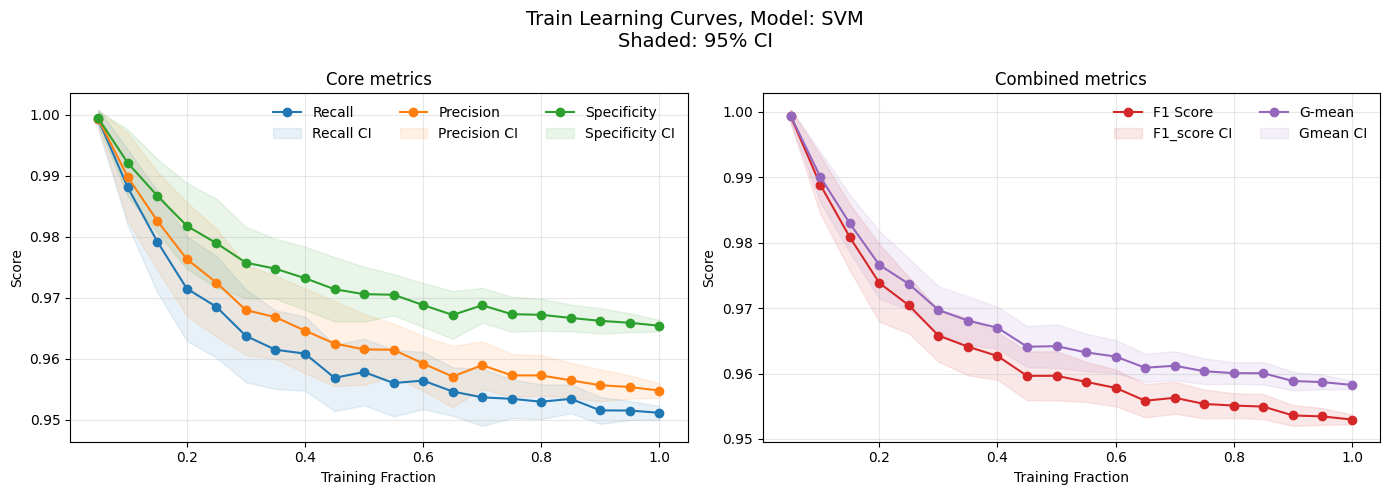

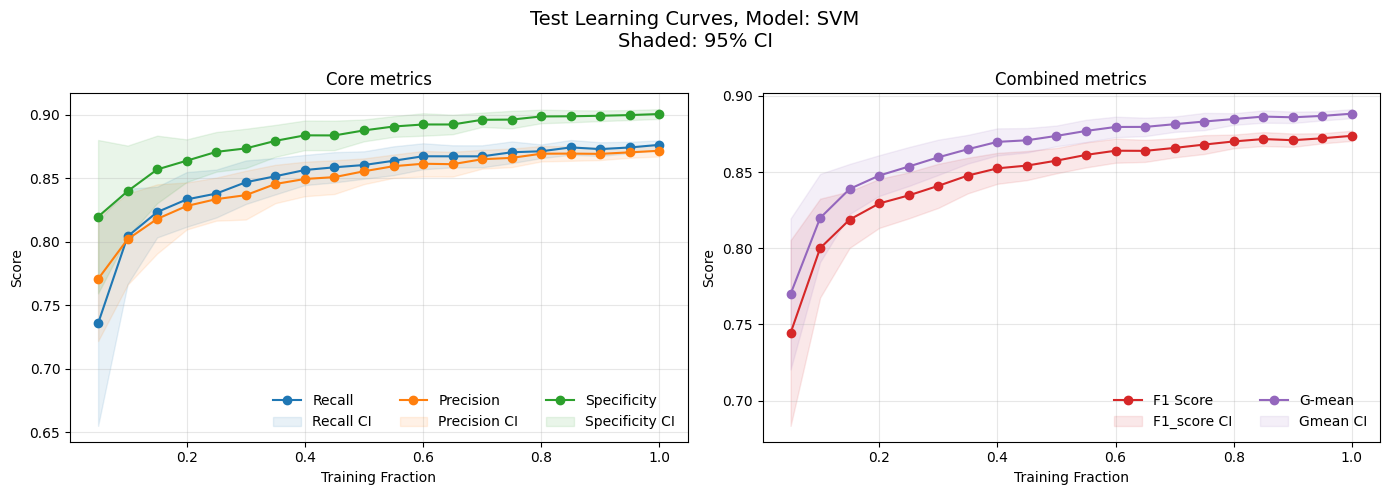

In [10]:
fig_std, axs_std = plot_learning_curves(results=train_results_svm, 
                                        core_metrics=core_metrics, combined_metrics=combined_metrics,
                                        plot_ci=True, ci_type = 'ci95', legend_ncols = 2,
                                        save_plot=True, save_folder='LearningCurves_config1',
                                        title_prefix = f"Train Learning Curves, Model: {model_name}\nShaded: 95% CI",
                                        save_name=f'train_LearningCurves_{model_name}_ci95.png', legend_loc = 'upper right')

fig_95, axs_95 = plot_learning_curves(results=test_results_svm, 
                                      core_metrics=core_metrics, combined_metrics=combined_metrics,
                                      plot_ci=True, ci_type = 'ci95', legend_ncols = 2,
                                      save_plot=True, save_folder='LearningCurves_config1',
                                      title_prefix = f"Test Learning Curves, Model: {model_name}\nShaded: 95% CI",
                                      save_name=f'test_LearningCurves_{model_name}_ci_95.png', legend_loc = 'lower right', 
                                      bbox_to_anchor=(1, 0))

# Reformatting the results dictionary to allow for easier joint bootstrapping of entire learning curves

In [11]:
import numpy as np
import warnings
from typing import Dict, Union, List, Tuple

def scores_matrix(
    results: Dict[float, Dict[str, Dict[str, Union[float, list]]]],
    metric: str,
    pad_value: float = np.nan,
    return_fracs: bool = True
) -> Union[np.ndarray, Tuple[np.ndarray, List[float]]]:
    """
    For a given metric and results dict, constructs a scores matrix for joint bootstrap resampling.

    Parameters
    ----------
    results : dict
        Dictionary of format {frac: {metric: {'scores': [...]}}}
    metric : str
        Metric key (e.g., 'f1', 'precision') to extract scores for.
    pad_value : float, default=np.nan
        Value to pad score lists with, if score counts vary.
    return_fracs : bool, default=True
        Whether to return the sorted list of sample fractions used.

    Returns
    -------
    scores_arr : np.ndarray
        2D array of shape (n_fracs, n_iterations)
    fracs : list of float
        Sorted list of sample fractions (only if return_fracs=True)
    """
    fracs = sorted(results.keys())
    scores_rows = []

    for frac in fracs:
        if metric not in results[frac]:
            warnings.warn(f"Missing metric '{metric}' at fraction {frac}")
            continue
        scores = results[frac].get(metric, {}).get('scores', [])
        scores = np.asarray(scores, dtype=float)
        if scores.size == 0:
            continue
        scores_rows.append(scores)

    if not scores_rows:
        raise ValueError(f"No scores found for metric '{metric}' in any fraction.")

    max_len = max(len(row) for row in scores_rows)
    scores_rows = [
        np.pad(row, (0, max_len - len(row)), constant_values=pad_value) if len(row) < max_len else row
        for row in scores_rows
    ]

    scores_arr = np.vstack(scores_rows)

    if return_fracs:
        return scores_arr, fracs
    else:
        return scores_arr

In [12]:
overall_metrics = ['recall', 'precision', 'specificity', 
                   'f1_score', 'gmean']
test_results_svm = joblib.load(bootstrap_results_dir/f'test_learning_curves_svm_{config}.pkl')

reformat_scores_dict = {}
for metric in overall_metrics:
    metric_name = metric+'_test'
    scores_arr, _ = scores_matrix(test_results_svm, metric_name, return_fracs=True)
    reformat_scores_dict[metric] = scores_arr
    
# Input data shape: (num_training_fracs, num_subsamples_per_frac), here, (20, 50)
# Each column corresponds to a full learning curve (across all fractions)
# Each row corresponds to the distribution of metric scores at a given training fraction
# Joint bootstrap resampling samples columns with replacement to preserve correlation across fractions
print(reformat_scores_dict['recall'].shape)
print(np.nanmean(reformat_scores_dict['recall'], axis = 1).shape) # mean value at each training fraction

(20, 50)
(20,)


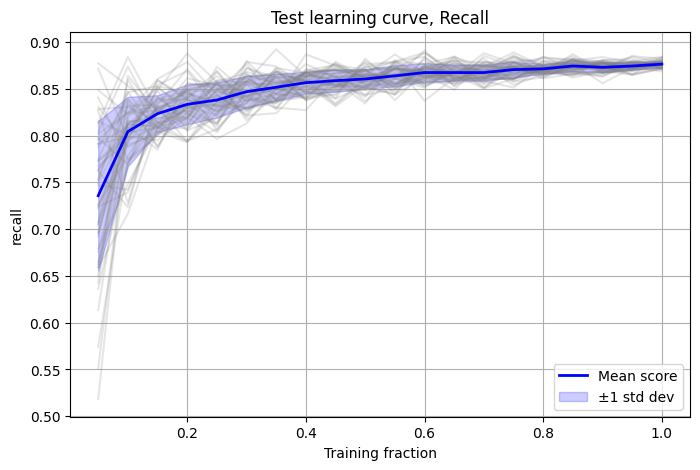

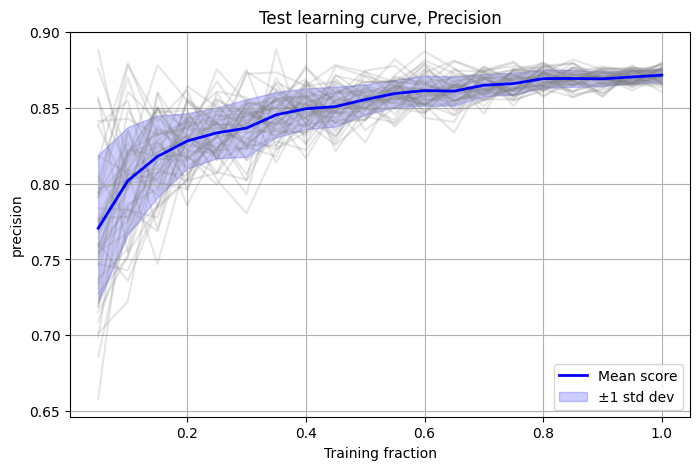

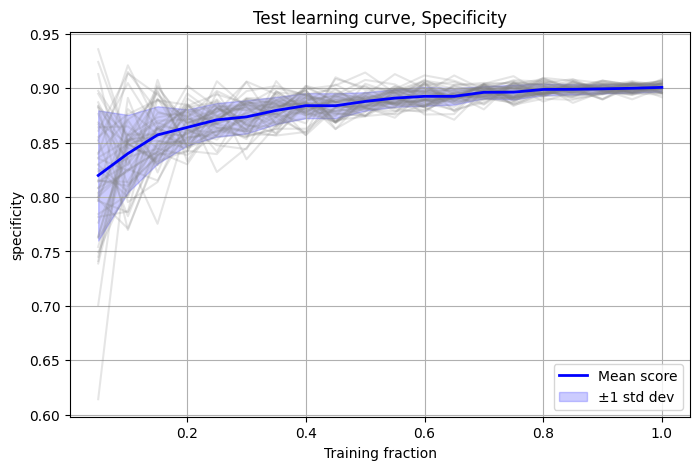

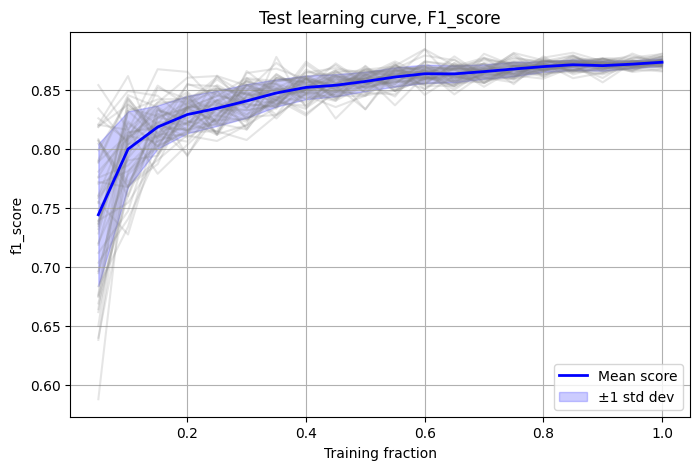

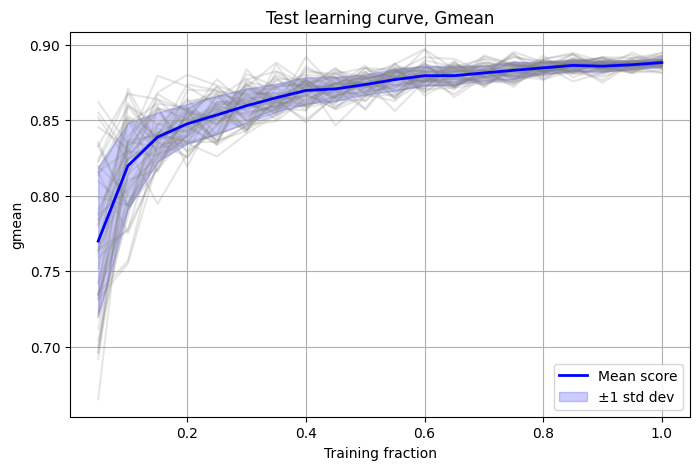

In [13]:
sample_fracs = np.linspace(0.05, 1.0, 20)

for metric in overall_metrics:
    scores_arr = reformat_scores_dict[metric]  # shape (n_fracs, n_iters)
    
    n_fracs, n_iters = scores_arr.shape
    fracs = sample_fracs
    
    plt.figure(figsize=(8, 5))
    # Plot each iteration's curve (light lines)
    for i in range(n_iters):
        plt.plot(fracs, scores_arr[:, i], color='gray', alpha=0.2) # scores_arr[:, i] stores the i(+1)-th learning curve
        
    # Plot mean curve
    mean_scores = np.nanmean(scores_arr, axis=1) # mean over all learning curves
    plt.plot(fracs, mean_scores, color='blue', linewidth=2, label='Mean score')

    # Add shaded std deviation region
    std_scores = np.nanstd(scores_arr, axis=1)
    plt.fill_between(fracs, mean_scores - std_scores, mean_scores + std_scores, 
                     color='blue', alpha = 0.2, label='±1 std dev')

    plt.title(f'Test learning curve, {metric.capitalize()}')
    plt.xlabel('Training fraction')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True)
    plt.show()

# Curve fitting and summary results

In [14]:
import numpy as np
from scipy.special import expit, logit

# Learning curve models
# Unbounded model (not constrained to (0,1))
def inv_power(n, a, b, c):
    # y = a - b * n^{-c}; asymptote at a
    n = np.asarray(n, float)
    return a - b * np.power(np.maximum(n, 1.0), -np.maximum(c, 1e-6))

# Sigmoid-transformed inverse power model (bounded in (0,1))
def logit_inv_power(n, a, b, c):
    # logit(y) = a - b * n^{-c} => y in (0,1)
    n = np.asarray(n, float)
    return expit(a - b * np.power(np.maximum(n, 1.0), -np.maximum(c, 1e-6)))

# Log-linear (not sigmoid-transformed)
# Unbounded model (not constrained to (0,1))
def loglinear(n, a, b):
    # y = a + b*log(n); unbounded
    n = np.asarray(n, float)
    return a + b * np.log(np.maximum(n, 1.0))

# Sigmoid-transformed log-linear model
def logit_loglinear(n, a, b):
    # logit(y) = a + b*log(n) => y in (0,1)
    n = np.asarray(n, float)
    return expit(a + b * np.log(np.maximum(n, 1.0)))

# Grid of sample fractions (e.g. for subsampling curves)
sample_fracs = np.linspace(0, 1.0, 20)

MODEL_SPECS = {
    "inv_power": {
        "func": inv_power,
        "p0": lambda n, y: (np.nanmax(y), max(np.nanmax(y) - np.nanmin(y), 1e-3), 0.5),
        "bounds": ([0.0, 0.0, 1e-3], [1.0, 1.0, 5.0]),
        "bounded_01": False,  # not sigmoid-transformed
    },
    "logit_inv_power": {
        "func": logit_inv_power,
        "p0": lambda n, y: (np.nanmax(y), max(np.nanmax(y) - np.nanmin(y), 1e-3), 0.5),
        "bounds": ([0.0, 0.0, 1e-3], [1.0, 1.0, 5.0]),
        "bounded_01": True,
    },
    "loglinear": {
        "func": loglinear,
        "p0": lambda n, y: (logit(np.clip(np.nanmedian(y), 1e-6, 1 - 1e-6)), 0.2),
        "bounds": ([-20.0, -5.0], [20.0, 5.0]),
        "bounded_01": False,  # not sigmoid-transformed
    },
    "logit_loglinear": {
        "func": logit_loglinear,
        "p0": lambda n, y: (logit(np.clip(np.nanmedian(y), 1e-6, 1 - 1e-6)), 0.2),
        "bounds": ([-20.0, -5.0], [20.0, 5.0]),
        "bounded_01": True,
    }
}

In [15]:
# Extract series from results
def extract_series(results: Dict, metric: str):
    """
    Extract a metric's data across all training fractions.

    Returns:
        fracs: sorted array of training fractions
        means: mean score per fraction
        stds: standard deviation per fraction
        ci_lo, ci_hi: 95% confidence interval bounds for score per fraction
        score_lists: list of raw bootstrap scores per fraction
    """
    fracs = np.array(sorted(results.keys()), float)
    means, stds, ci_lo, ci_hi, score_lists = [], [], [], [], []

    for f in fracs:
        d = results[f].get(metric, {})
        means.append(d.get("mean", np.nan))   # mean score
        stds.append(d.get("std", np.nan))     # std of score

        # Extract 95% CI if available, else NaNs
        if "ci95" in d and d["ci95"] is not None:
            lo, hi = d["ci95"]
        else:
            lo, hi = np.nan, np.nan
        ci_lo.append(lo)
        ci_hi.append(hi)

        # Bootstrap sample scores (may be empty if not recorded)
        score_lists.append(d.get("scores", []))

    return (fracs,
            np.array(means, float),
            np.array(stds, float),
            np.array(ci_lo, float),
            np.array(ci_hi, float),
            score_lists,)

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.optimize import curve_fit

@dataclass
class FitResult:
    fit_model: str
    params: np.ndarray
    pred_fn: Callable[[np.ndarray], np.ndarray]

def fit_curve(n_obs: np.ndarray,
              y_obs: np.ndarray,
              fit_model: str = "inv_power",
              sigma: Optional[np.ndarray] = None, track_errors: bool = False) -> FitResult:
    """
    Fit a specified learning-curve model to observed data.

    Args:
        n_obs: array of training sample sizes (x-values)
        y_obs: array of observed metric values (y-values)
        fit_model: name of model in MODEL_SPECS
        sigma: optional per-point standard deviations (used as weights)

    Returns:
        FitResult with best-fit parameters and a callable predictor.
    """
    # Look up the model's function, initial guess, and bounds
    spec = MODEL_SPECS[fit_model]
    func = spec["func"]

    # Keep only finite points (drop NaN or inf)
    mask = np.isfinite(n_obs) & np.isfinite(y_obs)
    n_fit, y_fit = n_obs[mask], y_obs[mask]

    # Ensure we have enough points to estimate all parameters
    n_params = len(np.atleast_1d(spec["p0"](n_fit, y_fit)))
    if n_fit.size < n_params:
        raise ValueError("Not enough finite points to fit the model.")

    # Clean sigma (if provided)
    if sigma is not None:
        sigma = np.asarray(sigma, float)[mask]
        if not np.isfinite(sigma).any():
            sigma = None
        else:
            # Replace NaNs/zeros with the median sigma
            med = np.nanmedian(sigma[np.isfinite(sigma)])
            sigma = np.where(np.isfinite(sigma) & (sigma > 1e-12), sigma, med)

    # Fit the model using nonlinear least squares
    popt, _ = curve_fit(func,
                        n_fit,
                        y_fit,
                        p0=spec["p0"](n_fit, y_fit),    # initial guess
                        bounds=spec["bounds"],          # parameter bounds
                        sigma=sigma,                    # weights (if available)
                        absolute_sigma=bool(sigma is not None),
                        maxfev=20000)
    rmse = None
    mae = None
    if track_errors:
        y_pred = func(n_fit, *popt)
        rmse = np.sqrt(mean_squared_error(y_fit, y_pred))
        mae = mean_absolute_error(y_fit, y_pred)

    # Return fitted parameters and a predictor function
    return FitResult(fit_model=fit_model, params=popt, pred_fn=lambda n: func(n, *popt)), rmse, mae

In [17]:
from typing import Callable, Optional, Tuple
from scipy.optimize import brentq
import numpy as np

def solve_required_n(pred_fn: Callable[[np.ndarray], np.ndarray],
                     target: float,
                     n_lower: float,
                     n_upper: Optional[float] = None,
                     max_expand: int = 14, expansion_coeff: float = 2.0,
                     debug: bool = False) -> Optional[Tuple[float, str]]:
    """
    Find the smallest n >= n_lower such that pred_fn(n) >= target.

    Expands an upper bracket exponentially (some float, default factor -> x2) and then uses brentq root-finding on:
        g(n) = pred_fn(n) - target

    Args:
        pred_fn: callable returning predicted metric for an array of n
        target: target metric value
        n_lower: starting point (minimum allowable n)
        n_upper: optional starting upper bound (if None, guesses one)
        max_expand: maximum number of bracket expansions before stopping
        debug: if True, prints debug info on bracket expansion

    Returns:
        (n_required, status) where:
            n_required: smallest n meeting target, or None if unreachable
            status: description of how the solution was found
    """
    f_lower = float(pred_fn([n_lower]))
    if f_lower >= target:
        return float(n_lower), 'Already meets or exceeds target'

    if n_upper is None:
        n_upper = max(n_lower * 2.0, n_lower + 1.0)

    # Bracket expansion
    for i in range(max_expand):
        f_upper = float(pred_fn([n_upper]))
        if debug:
            print(f"[debug] Bracket expansion iteration {i}: n_upper={n_upper}, pred={f_upper}")
        if f_upper >= target:
            # Have bracketed the target: solve for root of g(n) = pred_fn(n) - target
            g = lambda n: float(pred_fn([n]) - target)
            try:
                n_required = float(brentq(g, n_lower, n_upper, maxiter=200))
                return n_required, 'brentq root found'
            except ValueError:
                # Root finder failed (flat or non-monotonic region): return conservative upper bound
                return float(n_upper), 'brentq failed, using conservative upper bound'
        # Expand bracket if target not yet reached
        n_lower, n_upper = n_upper, n_upper * expansion_coeff # exponential expansion

    # Could not reach the target even after expanding bracket
    return None, "Exhausted bracket expansions, no roots found"

In [18]:
import numpy as np
from typing import Tuple, Union

def compute_target(means: np.ndarray,
                   improvement: Tuple[str, float],
                   benchmark: Union[float, str] = "max_observed",
                   clip01: bool = True) -> float:
    """
    Compute a target metric value based on a baseline benchmark and a specified improvement.

    Args:
        means: array of observed mean metric values (may contain NaNs).
        improvement: tuple ('add' or 'mult', value) specifying additive or multiplicative improvement over baseline.
        benchmark: either 'max_observed' to use max of means as baseline, or a numeric baseline value.
        clip01: whether to clip the target value between 0 and 1.

    Returns:
        A float target value representing the improved metric.
    """
    # Determine baseline
    if benchmark == "max_observed":
        base = float(np.nanmax(means))
    elif benchmark == 'first_observed':
        base = float(np.round(means[0], 3))
    elif isinstance(benchmark, (int, float)):
        base = float(benchmark)
    else:
        raise ValueError("benchmark must be 'max_observed', 'first_observed', or a numeric value")

    kind, val = improvement
    val = float(val)
    if kind == "add":
        target = base + val
    elif kind == "mult":
        target = base * val
    else:
        raise ValueError("improvement must be ('add', Δ) or ('mult', r)")

    return float(np.clip(target, 0.0, 1.0) if clip01 else target)

In [19]:
def set_baseline(means, benchmark):
    # Set baseline
    if benchmark == "max_observed":
        baseline = float(np.round(np.nanmax(means), 3))
    elif benchmark == "first_observed":
        baseline = float(np.round(means[0], 3))
    elif isinstance(benchmark, (int, float)):
        baseline = float(np.round(benchmark, 3))
    else:
        raise ValueError("Benchmark must be 'max_observed', 'first_observed', or a number")
    return baseline

In [20]:
def resolve_target(metric, mean, predict_settings, improve_specs, target_specs, benchmark, clip01=True):
    # set specified improvement
    if predict_settings == 'improvement':
        metric_improvement = improve_specs[metric] if isinstance(improve_specs, dict) else improve_specs
        return compute_target(mean, metric_improvement, benchmark=benchmark, clip01=clip01)
    # set specified target
    elif predict_settings == 'target':
        return target_specs[metric] if isinstance(target_specs, dict) else target_specs

In [21]:
def bootstrap_fits(scores_arr, n_obs, fit_model, target, n_bootstrap_fits, rng):
    n_iters = scores_arr.shape[1]
    n_reqs, rmses, maes = [], [], []

    for _ in range(n_bootstrap_fits):
        col_ids = rng.choice(n_iters, size=n_iters, replace=True)
        sampled = scores_arr[:, col_ids]
        mean = np.nanmean(sampled, axis=1)
        if not np.all(np.isfinite(mean)): continue
        sigma = np.clip(np.nanstd(sampled, axis=1), 1e-4, None)
        try:
            fit_b, rmse_b, mae_b = fit_curve(n_obs, mean, fit_model=fit_model, sigma=sigma, track_errors=True)
            n_b, _ = solve_required_n(fit_b.pred_fn, target, n_lower=float(n_obs.max()))
            if np.isfinite(n_b): n_reqs.append(n_b)
            rmses.append(rmse_b), maes.append(mae_b)
        except:
            continue
    return dict(n_reqs=n_reqs, rmses=rmses, maes=maes)

In [22]:
def fit_and_solve(n_obs, means, sigma, target, n_current_max, fitting_model):
    """
    Fit learning curve and solve for required n.

    Returns:
        (pred_fn, n_req, root_status, rmse, mae)
    """
    fit_mean, rmse, mae = fit_curve(n_obs, means, fit_model=fit_model, sigma=sigma, track_errors=True)
    n_req, root_status = solve_required_n(fit_mean.pred_fn, target, n_lower=float(n_current_max))
    return fit_mean.pred_fn, n_req, root_status, rmse, mae

In [23]:
def bootstrap_fit_and_solve(
    rng, scores_arr, n_obs, target, n_current_max, fitting_model, n_bootstrap_fits
):
    """
    Perform bootstrap resampling and fit to estimate uncertainty in required n.

    Returns:
        n_reqs_boot (List[float]), boot_rmses (List[float]), boot_maes (List[float])
    """
    n_iters = scores_arr.shape[1]
    n_reqs_boot = []
    boot_rmses = []
    boot_maes = []

    for _ in range(n_bootstrap_fits):
        col_ids = rng.choice(n_iters, size=n_iters, replace=True)
        sampled = scores_arr[:, col_ids]
        boot_mean = np.nanmean(sampled, axis=1)
        boot_sigma = np.clip(np.nanstd(sampled, axis=1), 1e-4, None)

        if not np.all(np.isfinite(boot_mean)):
            continue

        try:
            fit_b, rmse_b, mae_b = fit_curve(n_obs, boot_mean, fit_model=fitting_model, sigma=boot_sigma, track_errors=True)
            boot_rmses.append(rmse_b)
            boot_maes.append(mae_b)

            n_req_b, _ = solve_required_n(fit_b.pred_fn, target, n_lower=float(n_current_max))
            if n_req_b and np.isfinite(n_req_b):
                n_reqs_boot.append(float(n_req_b))

        except Exception:
            continue

    return n_reqs_boot, boot_rmses, boot_maes

In [24]:
def fit_metric(
    metric: str,
    scores_arr: np.ndarray,
    n_obs: np.ndarray,
    total_n_current: int,
    baseline_metrics: Dict[str, float],
    predict_settings: str,
    improve_specs: Optional[Union[Tuple[str, float], Dict[str, Tuple[str, float]]]],
    target_specs: Optional[Union[float, Dict[str, float]]],
    benchmark: Union[float, str],
    fit_model: Union[str, Dict[str, str]],
    use_sigma_from_std: bool,
    bootstrap_ci: bool,
    rng: np.random.RandomState,
    n_bootstrap_fits: int,
    expected_annotated_per_sample: int
) -> Tuple[Dict, Callable]:

    means, stds = np.nanmean(scores_arr, axis=1), np.nanstd(scores_arr, axis=1)
    n_current_max = int(np.round(np.nanmax(n_obs)))

    if not np.isfinite(means).any():
        return dict(metric=metric, fit_status="no_data"), None

    baseline_metrics[metric] = set_baseline(means, benchmark)
    target = resolve_target(metric, means, predict_settings, improve_specs, target_specs, benchmark, clip01=True)

    if target <= np.nanmax(means):
        return dict(metric=metric, baseline=baseline_metrics[metric], target=target, fit_status='already_above_target'), None

    sigma = stds if (use_sigma_from_std and np.isfinite(stds).any()) else None
    fitting_model = fit_model[metric] if isinstance(fit_model, dict) else fit_model

    try:
        pred_fn, n_req, root_status, rmse, mae = fit_and_solve(n_obs, means, sigma, target, n_current_max, fitting_model)
        if root_status != 'brentq root found':
            return dict(metric=metric, baseline=baseline_metrics[metric], target=target, fit_status=root_status,
                       new_samples_req=None,
                       new_samples_req_lo=None, new_samples_req_hi=None), None
    except Exception as e:
        return dict(metric=metric, baseline=baseline_metrics[metric], fit_status=f"fit_error: {e}",
                   new_samples_req=None, new_samples_req_lo=None, new_samples_req_hi=None), None

    if bootstrap_ci:
        n_reqs_boot, boot_rmses, boot_maes = bootstrap_fit_and_solve(rng, scores_arr, n_obs, target, 
                                                                     n_current_max, fitting_model, n_bootstrap_fits)
        if len(n_reqs_boot) < n_bootstrap_fits * 0.5:
            warnings.warn(f"Only {len(n_reqs_boot)}/{n_bootstrap_fits} bootstraps succeeded for {metric}")

        if n_req is None:
            row = dict(metric=metric, baseline=baseline_metrics[metric],
                       target=target, improve_specs=improve_specs[metric] if isinstance(improve_specs, dict) else improve_specs,
                       n_current=n_current_max, fitting_model=fitting_model,
                       fit_status="unreachable_under_model", root_status=root_status,
                       rmse=None, mae=None, rmse_uncertainty=None, mae_uncertainty=None,
                       n_required=None, delta_n=None, new_samples_req=None,
                       new_samples_req_lo=None, new_samples_req_hi=None, ci95_n_lo=None, ci95_n_hi=None)
        else:
            ci95_n_lo = np.percentile(n_reqs_boot, 2.5) if n_reqs_boot else n_req
            ci95_n_hi = np.percentile(n_reqs_boot, 97.5) if n_reqs_boot else n_req

            delta_n = int(round(max(0.0, n_req - n_current_max)))
            ci95_delta_n_lo = int(round(max(0.0, ci95_n_lo - n_current_max)))
            ci95_delta_n_hi = int(round(max(0.0, ci95_n_hi - n_current_max)))

            new_samples_req = max(0, (n_req - n_current_max) / expected_annotated_per_sample)
            new_samples_req_lo = max(0, (ci95_n_lo - n_current_max) / expected_annotated_per_sample)
            new_samples_req_hi = max(0, (ci95_n_hi - n_current_max) / expected_annotated_per_sample)

            row = dict(metric=metric, baseline=baseline_metrics[metric], target=target,
                       improve_specs=improve_specs[metric] if isinstance(improve_specs, dict) else improve_specs,
                       fitting_model=fitting_model, fit_status="ok", root_status=root_status,
                       rmse=rmse, mae=mae,
                       rmse_uncertainty=np.std(np.asarray(boot_rmses, float)),
                       mae_uncertainty=np.std(np.asarray(boot_maes, float)),
                       n_current=n_current_max, n_required=int(round(n_req)),
                       ci95_n_lo=int(np.round(ci95_n_lo)), ci95_n_hi=int(np.round(ci95_n_hi)),
                       delta_n=delta_n, ci95_delta_n_lo=ci95_delta_n_lo, ci95_delta_n_hi=ci95_delta_n_hi,
                       new_samples_req=int(np.ceil(new_samples_req)), new_samples_req_lo=int(np.ceil(new_samples_req_lo)),
                       new_samples_req_hi=int(np.ceil(new_samples_req_hi)))
    else:
        raise NotImplementedError("Only bootstrap CI mode is currently supported.")

    return row, pred_fn

In [25]:
import numpy.typing as npt

def calc_n_required(
    reformat_results: npt.ArrayLike,
    fracs: npt.ArrayLike,
    metrics: List[str],
    total_n_current: int,
    improve_specs: Optional[Union[Tuple[str, float], Dict[str, Tuple[str, float]]]] = None,
    target_specs: Optional[Union[float, Dict[str, float]]] = None,
    predict_settings: str = 'improvement',
    benchmark: Union[float, str] = "max_observed",
    fit_model: Union[str, Dict[str, str]] = "inv_power",
    bootstrap_ci: bool = True,
    n_bootstrap_fits: int = 400,
    random_state: int = 42,
    use_sigma_from_std: bool = True,
    save_path: Optional[str] = None,
    expected_annotated_per_sample: int = 183,
    return_summary: bool = False
) -> Tuple[pd.DataFrame, Dict[str, Callable]]:

    """
    Estimate the number of additional annotated samples required to achieve
    specified improvements or targets in ML model performance metrics by fitting and extrapolating
    learning curves. Joint bootstraps of the learning curves are fitted and extrapolated to
    determine bounds on the number of required training samples.

    Parameters
    ----------
    reformat_results : Dict[str, np.ndarray]
        Dictionary of shape {metric: scores_array}, where each array is (n_fracs, n_bootstraps),
        i.e., each column is a full learning curve, and each row is a distribution of scores 
        for a specific training fraction.
    metrics : List[str]
        List of performance metric names to evaluate (e.g., ["sensitivity", "F1"]).
    total_n_current : int
        Current total number of annotated data points (e.g., pixels).
    predict_settings : str, default='improvement'
        - "improvement": Compute required samples to improve upon a baseline (see improve_specs).
        - "target": Compute required samples to reach an absolute performance target (see target_specs).
        or "target" to treattarget_specs as absolute target values.
    improve_specs : Tuple[str, float] or Dict[str, Tuple[str, float]]
        Improvement targets. Each can be:
            - ("add", 0.02): additive increase over baseline
            - ("mult", 1.02): multiplicative increase over baseline
        Can be a single global value or specified per metric.
    target_specs: float or Dict[str, float]
        Specified target values of the forms:
        - target_value: all metrics have same target value
        - {metric': target_value}: each metric has its own assigned target value
    benchmark : str or float, default="max_observed"
        Baseline to improve upon. Options:
            - "max_observed": best observed score
            - "first_observed": score at smallest training size
            - float: fixed baseline value
    fit_model : str or Dict[str, str], default="inv_power"
        Curve fitting model to use, e.g., "inv_power", "log", "exp".
        Can be a single fitting model or a dict specifying one per metric.
    bootstrap_ci : bool, default = True
        Method for uncertainty estimation. Currently only "bootstrap" is supported.
    n_bootstrap_fits : int, default=400
        Number of bootstrap resamples to estimate uncertainty in n_required.
    random_state : int, default=42
        Random seed for reproducibility.
    use_sigma_from_std : bool, default=True
        Whether to use observed standard deviations when fitting curves.
    save_path : str or None, default=None
        If given, saves the resulting DataFrame as a CSV at the specified path.
    expected_annotated_per_sample : int, default=183
        Median number of annotated pixels per new sample, used to translate pixel
        requirements into sample counts.

    Returns
    -------
    Tuple[pd.DataFrame, Dict[str, Callable]]
        - DataFrame summarising required additional samples per metric, with bounds.
        - Dictionary of fitted prediction functions per metric.
    """
    assert predict_settings in ['improvement', 'target'],\
        "Parameter predict_settings must be either 'improvement' or 'target'." 

    if predict_settings == "improvement" and improve_specs is None:
        raise ValueError("If predict_settings is 'improvement', improve_specs must be provided.")
    elif predict_settings == "target" and target_specs is None:
        raise ValueError("If predict_settings is 'target', target_specs must be provided.")
    
    rng = np.random.RandomState(random_state)
    rows = []
    pred_fns = {}
    baseline_metrics = {}

    # Map fracs -> absolute Ns (numbers of pixels)
    n_obs = np.maximum(1.0, np.round(fracs * total_n_current))
    n_current_max = int(np.round(np.nanmax(n_obs)))

    for metric in metrics:
        scores_arr = reformat_results[metric]
        row, pred_fn = fit_metric(
            metric, scores_arr, n_obs, total_n_current, baseline_metrics,
            predict_settings, improve_specs, target_specs, benchmark,
            fit_model, use_sigma_from_std, bootstrap_ci, rng,
            n_bootstrap_fits, expected_annotated_per_sample
        )
        rows.append(row)
        if pred_fn is not None:
            pred_fns[metric] = pred_fn

    df = pd.DataFrame(rows)
    
    if return_summary:
        df_summary = df[["metric", "baseline", "target", "new_samples_req", "new_samples_req_lo", "new_samples_req_hi"]]

    if save_path is not None:
        if return_summary:
            df_summary.to_csv(save_path, index=False)
        else:
            df.to_csv(save_path, index=False)
        print(f"Dataframe saved as .csv at: {save_path}")

    return (df_summary, pred_fns) if return_summary else (df, pred_fns)

Dataframe saved as .csv at: LearningCurves_config1/LCAnalysis_inv_power_svm_full.csv
Dataframe saved as .csv at: LearningCurves_config1/LCAnalysis_inv_power_svm_summary.csv
Dataframe saved as .csv at: LearningCurves_config1/LCAnalysis_logit_inv_power_svm_full.csv
Dataframe saved as .csv at: LearningCurves_config1/LCAnalysis_logit_inv_power_svm_summary.csv
Dataframe saved as .csv at: LearningCurves_config1/LCAnalysis_loglinear_svm_full.csv
Dataframe saved as .csv at: LearningCurves_config1/LCAnalysis_loglinear_svm_summary.csv
Dataframe saved as .csv at: LearningCurves_config1/LCAnalysis_logit_loglinear_svm_full.csv
Dataframe saved as .csv at: LearningCurves_config1/LCAnalysis_logit_loglinear_svm_summary.csv


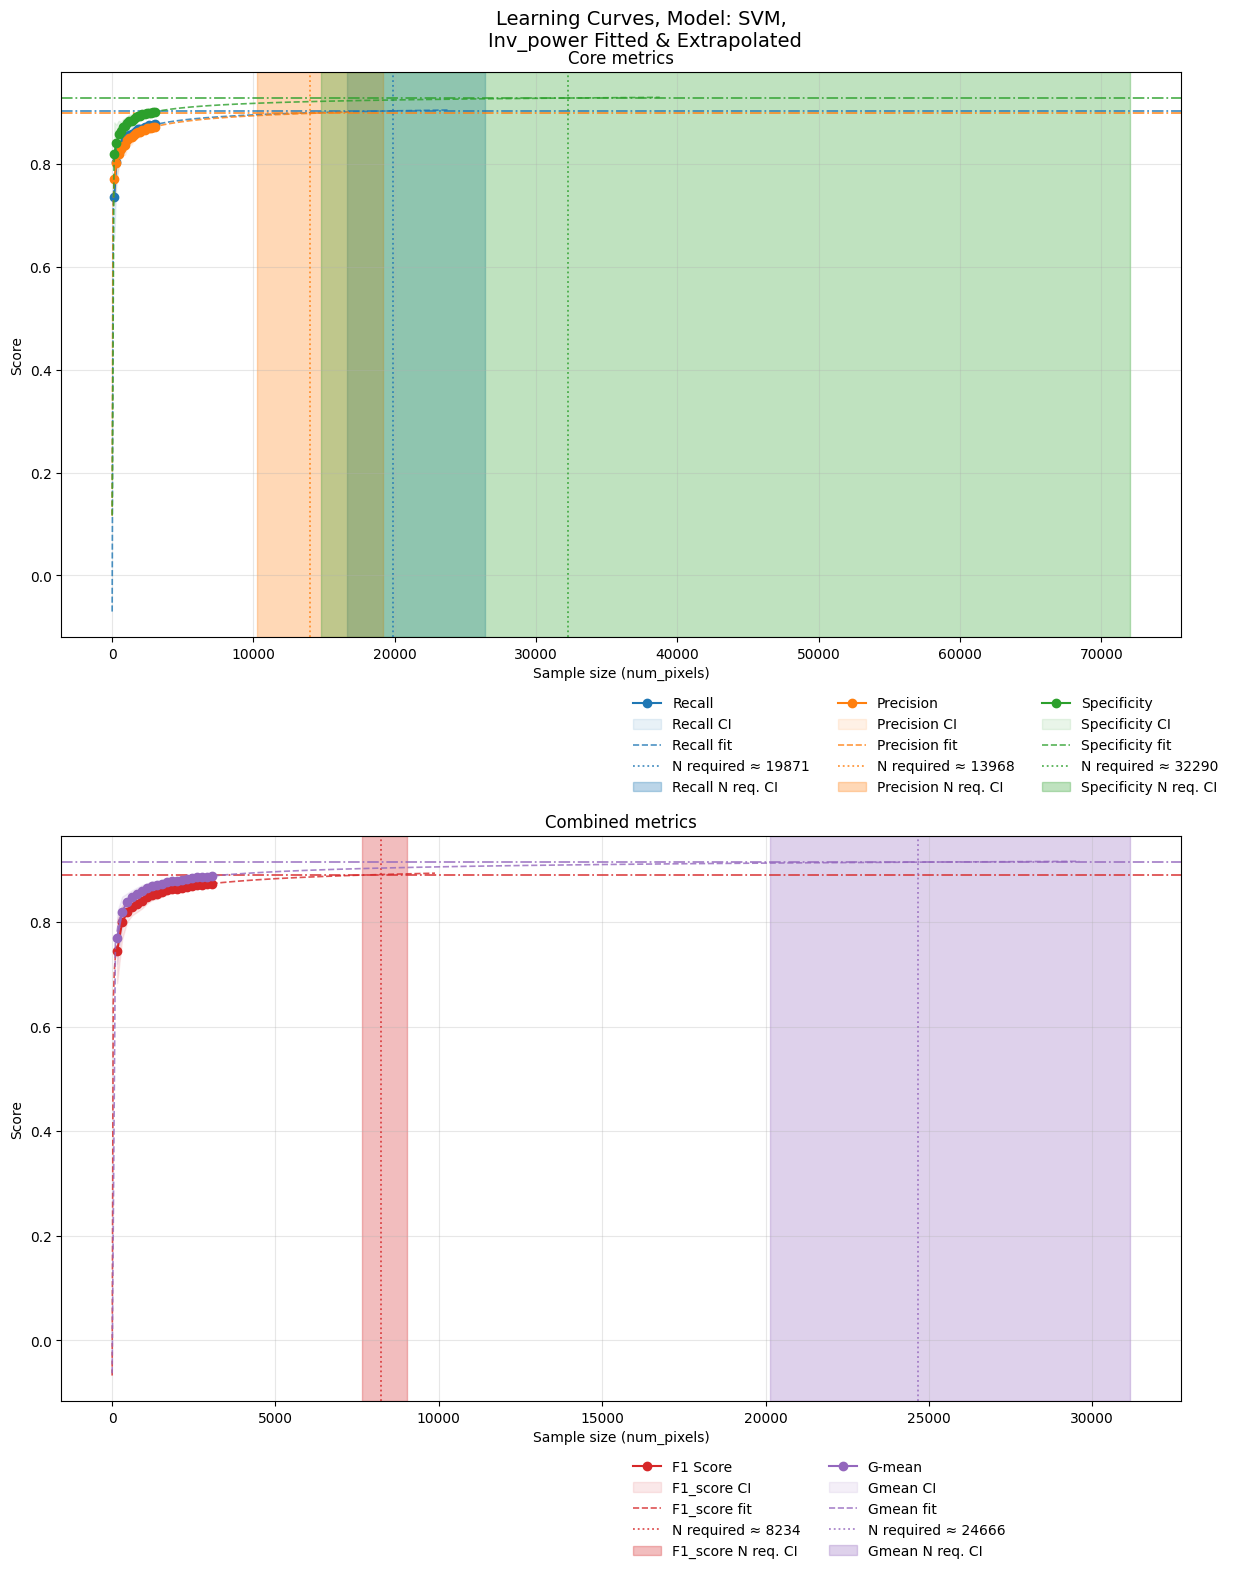

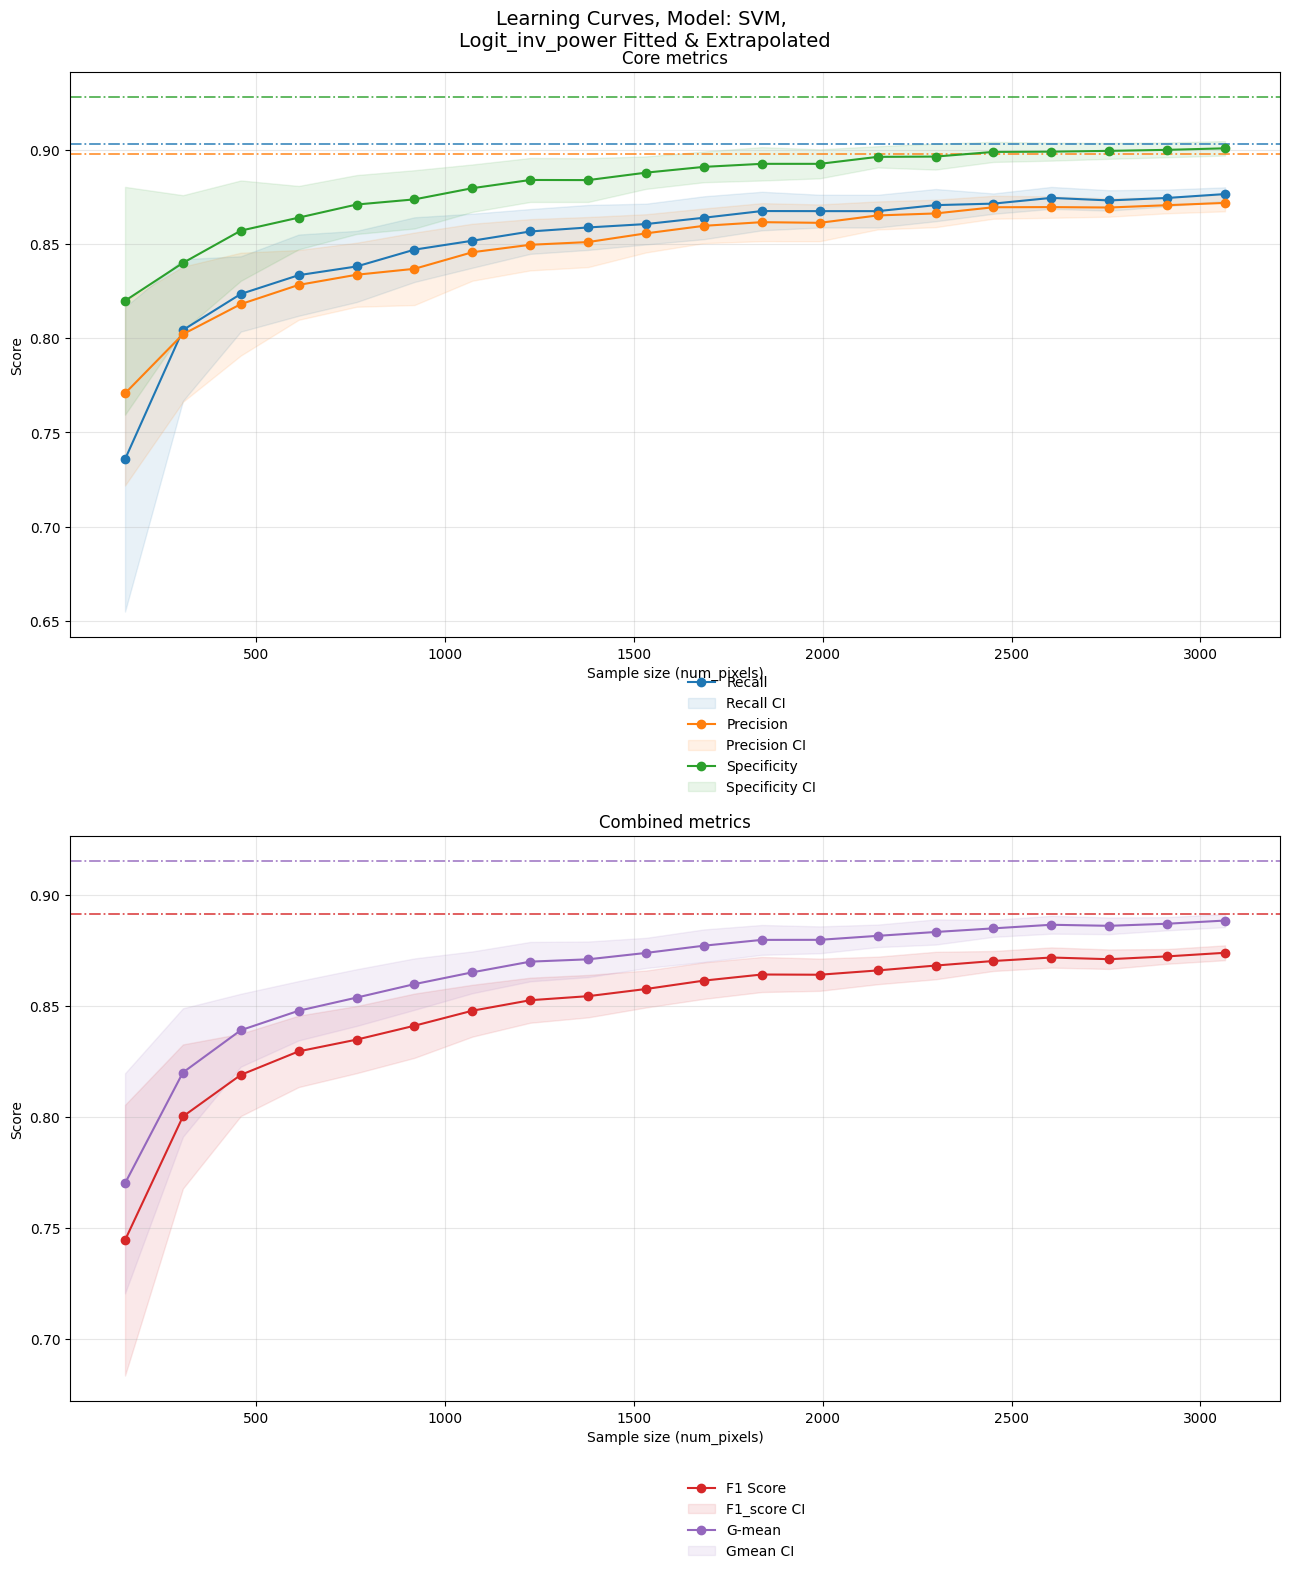

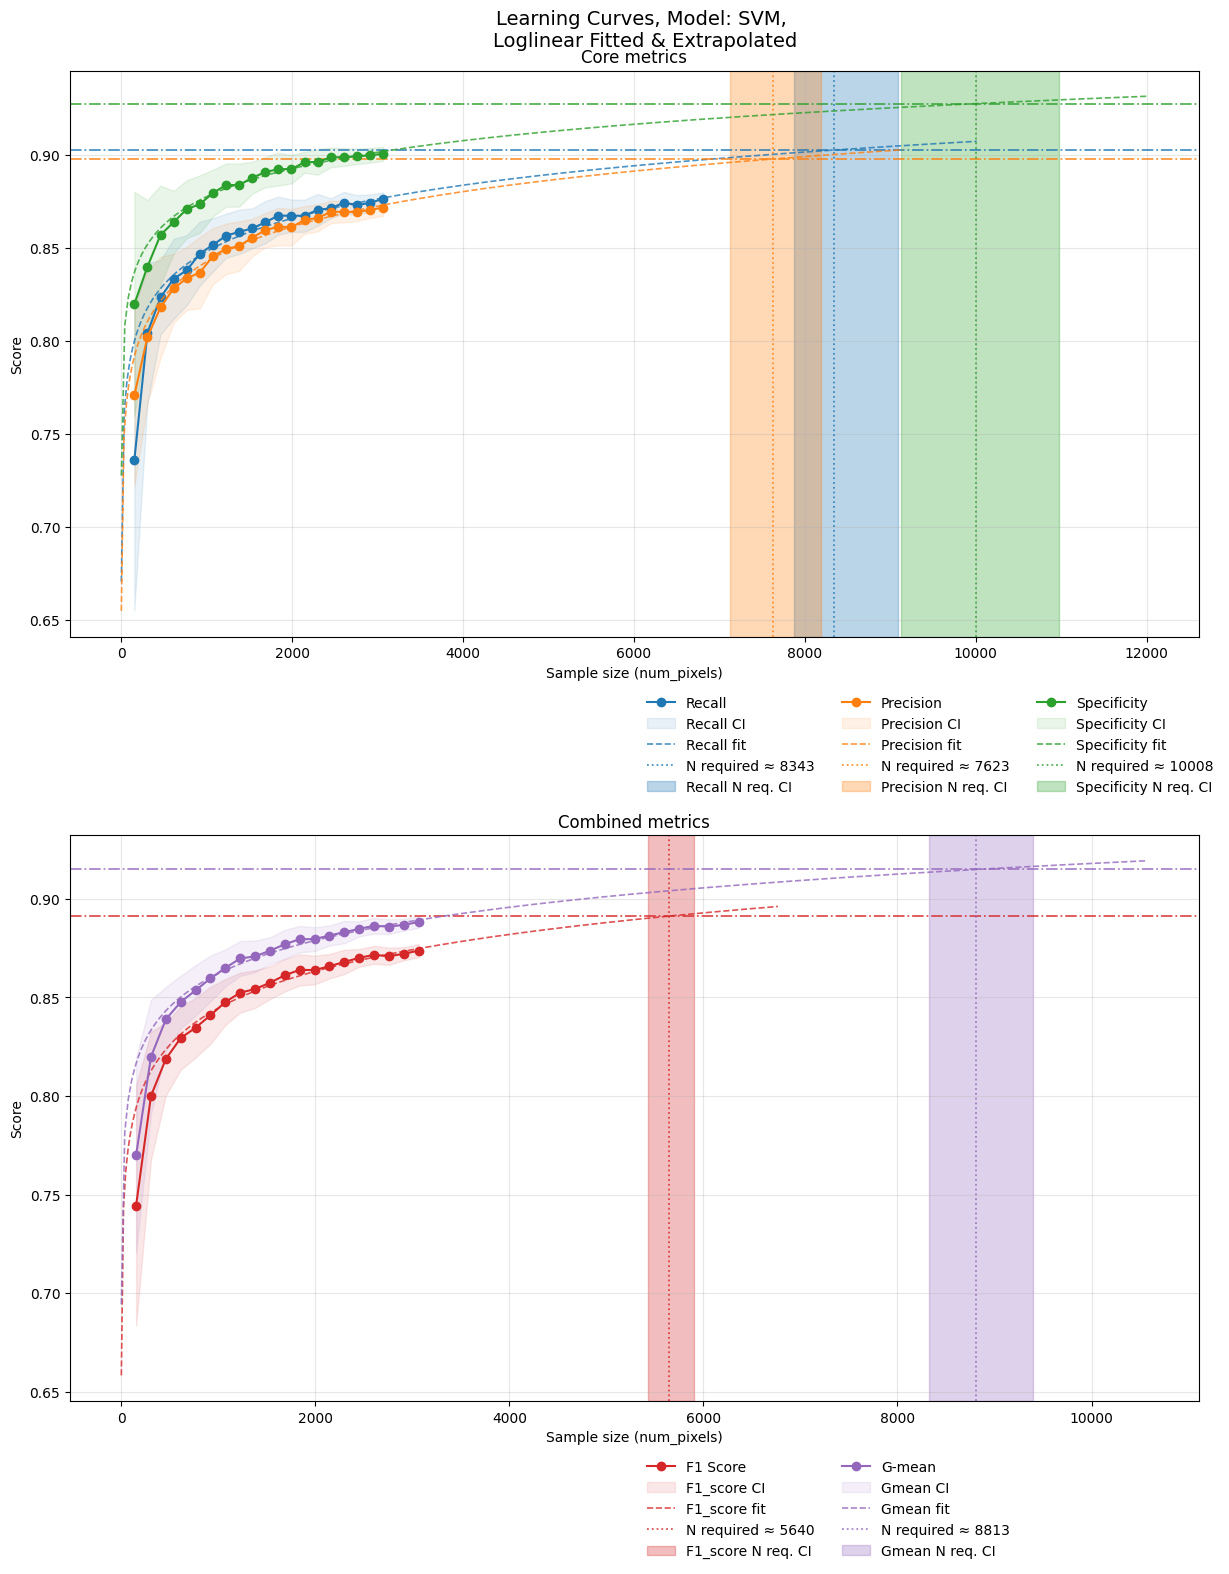

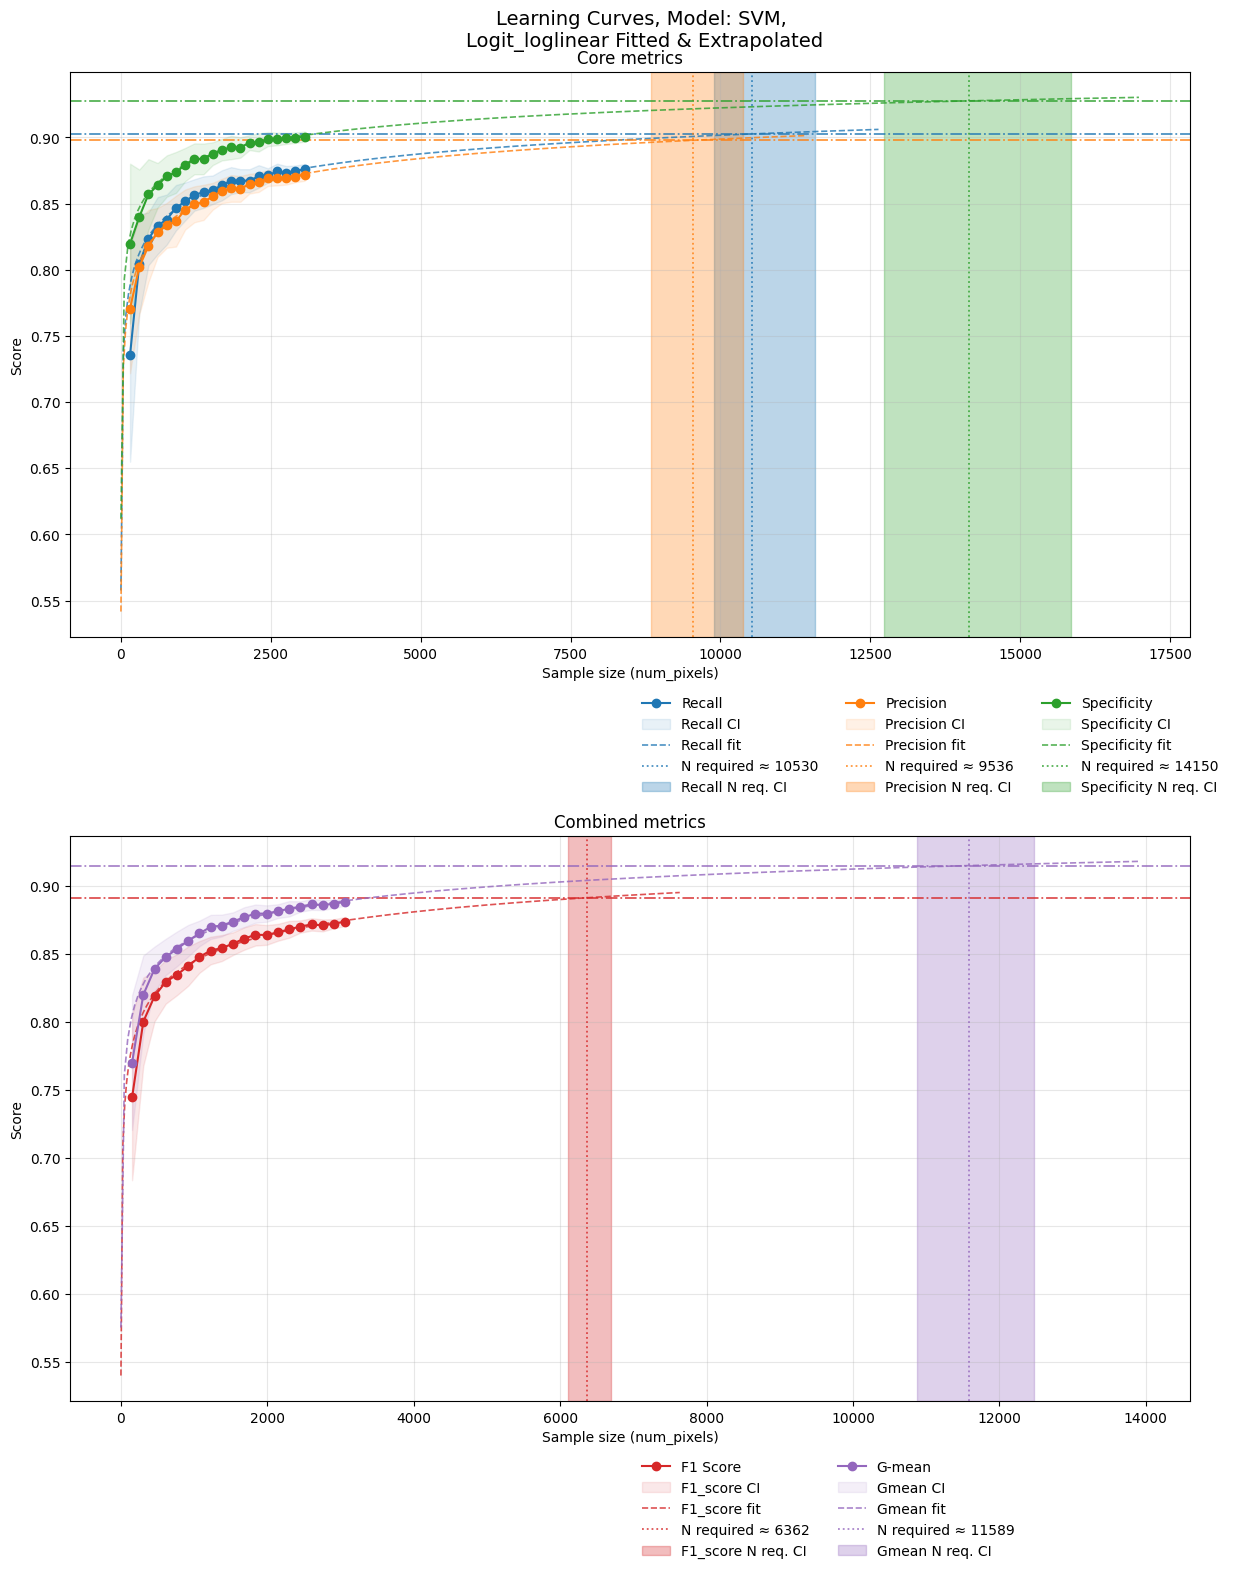

In [26]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

metrics_to_plan = ["precision", "recall", "specificity", "gmean", "f1_score"]
expected_annotated_per_sample = 180

improvements_dict = {"precision":   ("mult", 1.03), 
                     "recall": ("mult", 1.03), 
                     "specificity": ("mult", 1.03), 
                     "gmean":       ("mult", 1.03), 
                     "f1_score":    ("mult", 1.02)}

fit_models = ["inv_power", "logit_inv_power", "loglinear", "logit_loglinear"]
for fit_model in fit_models:
    # Use the same fitting model for all metrics
    fitting_models_dict = {"precision": fit_model, 
                         "recall":      fit_model,
                         "specificity": fit_model, 
                         "gmean":       fit_model, 
                         "f1_score":    fit_model}
    
    sample_fracs = np.linspace(0.05, 1.0, 20)
    df_plan, pred_fns = calc_n_required(
        reformat_results=reformat_scores_dict,
        fracs = sample_fracs,
        metrics = metrics_to_plan,
        total_n_current=len(X),
        predict_settings='improvement',
        improve_specs=improvements_dict,
        fit_model=fitting_models_dict,
        bootstrap_ci = True,
        expected_annotated_per_sample = expected_annotated_per_sample,
        save_path=f"LearningCurves_config1/LCAnalysis_{fit_model}_svm_full.csv", return_summary = False
    )
    df_plan_summary, _ = calc_n_required(
        reformat_results=reformat_scores_dict,
        fracs = sample_fracs,
        metrics = metrics_to_plan,
        total_n_current=len(X),
        predict_settings='improvement',
        improve_specs=improvements_dict,
        fit_model=fitting_models_dict,
        bootstrap_ci = True,
        expected_annotated_per_sample = expected_annotated_per_sample,
        save_path=f"LearningCurves_config1/LCAnalysis_{fit_model}_svm_summary.csv", return_summary = True
    )
    plot_learning_curves(
        test_results_svm,
        core_metrics=core_metrics,
        combined_metrics=combined_metrics,
        overlay_extrapolation=True,
        extrapolation_df=df_plan,
        pred_fns=pred_fns,
        total_n_current=len(X),
        plot_layout='vertical',
        figsize = (13, 16),
        title_prefix = f"Learning Curves, Model: {model_name}, \n{fit_model.capitalize()} Fitted & Extrapolated",
        save_plot=True,
        save_folder='LearningCurves_config1',
        save_name = f'fit&extrapolate_{fit_model}_LearningCurves_{model_name}_ci_95.png',
        legend_loc = 'lower left',
        legend_ncols = 5, bbox_to_anchor = (0.5, -0.3)
    )